In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [74]:
def image_quality_measure(frame, debug=False, i=0, j=0, frame_num=0):
    """
    Mide la calidad de la imagen en el dominio de la frecuencia para una matriz de enfoque compuesta
    por un arreglo de NxM elementos rectangulares equiespaciados.
    
    Parámetros:
    frame (numpy.ndarray): La imagen de entrada en escala de grises.
    n (int): Número de elementos en la dirección vertical.
    m (int): Número de elementos en la dirección horizontal.
    spacing (int): Espaciado entre los elementos.
    img_size (tuple): Tamaño de la imagen generada (ancho, alto).

    Retorno:
    float: La medida de calidad promedio de la imagen (FM).
    numpy.ndarray: Imagen con la cuadrícula dibujada.
    """

    # Paso 1: Calcular F, que es la representación de la Transformada de Fourier de la imagen I
    F = np.fft.fft2(frame)
    
    if debug:
        print('F.shape = ', F.shape)
    
    # Paso 2: Obtener Fc, que se obtiene desplazando F al centro
    Fc = np.fft.fftshift(F)

    if frame_num == 100:
        cv2.imwrite(f'frame100_{i}_{j}.jpg', frame)
        magnitude_spectrum = np.log(np.abs(Fc) + 1)  # Añadir 1 para evitar log(0)
        magnitude_spectrum = np.uint8(255 * magnitude_spectrum / np.max(magnitude_spectrum))
        cv2.imwrite(f'frame100_{i}_{j}_fft.jpg', magnitude_spectrum)

    if debug:
        print('Fc.shape = ', Fc.shape)
    
    # Paso 3: Calcular AF = abs(Fc), siendo AF el valor absoluto de la Transformada de Fourier centrada de la imagen I
    AF = np.abs(Fc)

    if debug:
        print('AF.shape = ', AF.shape)
    
    # Paso 4: Calcular M = max(AF), siendo M el valor máximo del componente de frecuencia en F
    M = np.max(AF)
    
    # Paso 5: Calcular TH = el número total de píxeles en F cuyo valor de píxel > thres, donde thres = M/1000
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular la medida de calidad de la imagen (FM) a partir de la ecuación presentada en el paper: FM = TH / (M * N)
    FM = TH / (frame.shape[0] * frame.shape[1])

    if debug:
        print('F.shape = ', F.shape)
        print(f"Valor máximo (M): {M}")
        print(f"Umbral (thres): {thres}")
        print(f"Número total de píxeles (TH): {TH}")
        print(f"Tamaño de la imagen (M*N): {frame.shape[0] * frame.shape[1]}")
    
    return FM



In [87]:
def measure_quality_over_grid(frame_rgb, n, m, roi_area, spacing=10, debug=False, frame_num=0):
    """
    Mide la calidad de la imagen en el dominio de la frecuencia para una matriz de enfoque compuesta
    por un arreglo de NxM elementos rectangulares equiespaciados.
    
    Parámetros:
    frame_rgb (numpy.ndarray): La imagen de entrada en formato RGB.
    n (int): Número de elementos en la dirección vertical.
    m (int): Número de elementos en la dirección horizontal.
    spacing (int): Espaciado entre los elementos.
    img_size (tuple): Tamaño de la imagen generada (ancho, alto).

    Retorno:
    float: La medida de calidad promedio de la imagen (FM).
    numpy.ndarray: Imagen con la cuadrícula dibujada.
    """
    fm_values = []
    img_with_grid = frame_rgb.copy()
    frame = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)

    # Calcular el área total de la imagen
    frame_area = frame.shape[0] * frame.shape[1]
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Calcular el área total de los elementos (10% del área de la imagen)
    total_element_area = roi_area * frame_area

    # Calcular el tamaño de cada elemento cuadrado
    element_side = int(np.sqrt(total_element_area / (n * m)))

    # Calcular el tamaño total que ocupará la cuadrícula
    total_width = m * element_side + (m - 1) * spacing
    total_height = n * element_side + (n - 1) * spacing

    # Calcular los márgenes para centrar la cuadrícula
    start_x = (frame_width - total_width) // 2
    start_y = (frame_height - total_height) // 2

    # Dividir la imagen en NxM rectángulos y medir la calidad para cada uno
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            if x_end < frame_width and y_end < frame_height:
                # Recortar el rectángulo de la imagen
                roi = frame[y_start:y_end, x_start:x_end]
                
                # Calcular la medida de calidad para este rectángulo
                quality_measure = image_quality_measure(roi, debug, i=i, j=j, frame_num=frame_num)
                fm_values.append(quality_measure)

                rectangle_color = (0, 255, 0) if quality_measure > 0.7 else (0, 0, 255)

                if debug:
                    cv2.putText(img_with_grid, f"{quality_measure:.2f}", (x_start, y_start + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, rectangle_color, 1)

    # Calcular el promedio de las medidas de calidad de los rectángulos
    average_fm = np.median(fm_values)

    # Determinar el color de los rectángulos según la medida de calidad promedio
    rectangle_color = (0, 255, 0) if average_fm > 0.7 else (0, 0, 255)

    # Dibujar los rectángulos en la imagen con el color determinado
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            if x_end < frame_width and y_end < frame_height:
                # Dibujar el rectángulo
                cv2.rectangle(img_with_grid, (x_start, y_start), (x_end, y_end), rectangle_color, 2)
                #cv2.putText(img_with_grid, f"{fm_values[i * m + j]:.2f}", (x_start, y_start + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, rectangle_color, 1)

    return average_fm, img_with_grid

In [88]:

def procesar_video(video_path, matrix=None, roi_area=0.1, debug=False):

    captura_video = cv2.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        # Obtén las dimensiones del video
        frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Obtén la tasa de cuadros (frame rate) del video
        fps = int(captura_video.get(cv2.CAP_PROP_FPS))
        fps = 35
        delay = int(1000 / fps)

        frame_numbers = []
        quality_measures = []
        
        paused = False

        while True:
            if not paused:
                ret, frame = captura_video.read()
                if not ret:
                    break

                frame_num = captura_video.get(cv2.CAP_PROP_POS_FRAMES)

                # Reducir el tamaño del frame
                frame_resized = cv2.resize(frame, (frame_width, frame_height))

                # Calcular la medida de calidad sobre la cuadrícula
                if matrix is not None:
                    quality_measure, frame_resized = measure_quality_over_grid(frame_resized, matrix[0], matrix[1], roi_area, debug=debug)
                else:
                    frame_resized_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
                    quality_measure = image_quality_measure(frame_resized_gray, debug=debug)

                frame_numbers.append(frame_num)
                quality_measures.append(quality_measure)

                # Mostrar la medida de calidad promedio en el video
                cv2.putText(frame_resized, f"Mediana metrica: {quality_measure:.2f}", (10, frame_height - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                
                # Mostrar el frame combinado
                cv2.imshow('Video con matriz de enfoque', frame_resized)
                
            key = cv2.waitKey(delay if not paused else 0) & 0xFF
            if key == ord('q'):
                break
            elif key == ord(' '):
                paused = not paused

        # Graficar número de frame vs medida de la métrica
        plt.figure()
        plt.plot(frame_numbers, quality_measures, marker='o', linestyle='-', color='b')
        plt.xlabel('# Frame')
        plt.ylabel('Métrica (ISM)')
        plt.title('Métrica (ISM) vs # Frame')
        plt.grid(True)
        plt.show()

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv2.destroyAllWindows()

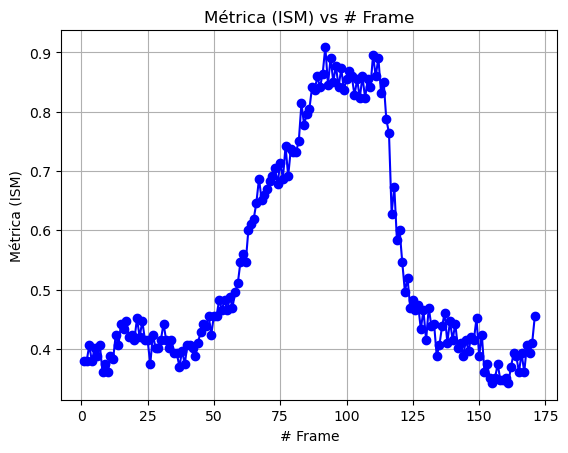

In [91]:
procesar_video('focus_video.mov', matrix=(7,7), debug=False)